### Batch Normalization Version 3

##### Target:
Add Batch Normalization in each convolution block except the last layer.

##### Results:
1. Parameters: 7612
2. Best Train Accuracy: 99.15%
3. Best Test Accuracy: 99.17%

##### Analysis:
1. The Batch normalization helped to push the train and test accuracies than the previous model.
2. Have not met the requirement of 99.4 % test accuracy.
3. Implement LR Schedulers in the next version to improve the accuracy.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

### Data Statics

In [12]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data',train = True,transform=simple_transforms,download=True)
exp_data = dataset.train_data
exp_data = dataset.transform(exp_data.numpy())

print('[Train]')
print('-Numpy Shape:',dataset.train_data.cpu().numpy().shape)
print('-Tensor Shape:',dataset.train_data.size())
print('-min:',torch.min(exp_data))
print('-max:',torch.max(exp_data))
print('-mean:',torch.mean(exp_data))
print('-std:',torch.std(exp_data))
print('-var:',torch.var(exp_data))

[Train]
-Numpy Shape: (60000, 28, 28)
-Tensor Shape: torch.Size([60000, 28, 28])
-min: tensor(0.)
-max: tensor(1.)
-mean: tensor(0.1307)
-std: tensor(0.3081)
-var: tensor(0.0949)


 ### Data Transformation

 We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [13]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
     ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

### Create Train and Test Data

In [14]:
train = datasets.MNIST('./data',train=True,transform=train_transforms)
test = datasets.MNIST('./data',train=False,transform=train_transforms)

### Dataloader Arguments

In [15]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available ?:",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True,batch_size = 64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available ?: True


### The Model Architecture

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    ) #Input size = 28, Output Size = 26, RFout = 3

    #Convolution Block 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    ) #Input size = 26, Output Size = 24, RFout = 5

    #Transition Block 1
    self.pool1 = nn.MaxPool2d(2,2) #Input size = 24, Output Size = 12, RFout = 6
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    )#Input size = 12, Output Size = 12, RFout = 6

    #Convolution Block 2
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    )#Input size = 12, Output Size = 10, RFout = 10
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32)
    )#Input size = 10, Output Size = 8, RFout = 14

    #Output block
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=10)
    )#Input size = 8, Output Size = 8, RFout = 14
    self.convblock7 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(8,8))
    )#Input size = 8, Output Size = 1, RFout = 28

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)



### Check the model parameters

In [17]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
      BatchNorm2d-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

Training and Testing

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Train the Model

In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
  print("EPOCH:",epoch)
  train(model, device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

EPOCH: 0


Loss=0.31839773058891296 Batch_id=468 Accuracy=88.80: 100%|██████████| 469/469 [00:24<00:00, 19.44it/s]



Test set: Average loss: 0.2096, Accuracy: 9684/10000 (96.84%)

EPOCH: 1


Loss=0.13799284398555756 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]



Test set: Average loss: 0.1199, Accuracy: 9771/10000 (97.71%)

EPOCH: 2


Loss=0.19438403844833374 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]



Test set: Average loss: 0.0842, Accuracy: 9836/10000 (98.36%)

EPOCH: 3


Loss=0.06252170354127884 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0845, Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.10462790727615356 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]



Test set: Average loss: 0.0633, Accuracy: 9862/10000 (98.62%)

EPOCH: 5


Loss=0.058799806982278824 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 0.0600, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


Loss=0.05664271488785744 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0538, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Loss=0.02994503080844879 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0483, Accuracy: 9884/10000 (98.84%)

EPOCH: 8


Loss=0.0699331983923912 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]



Test set: Average loss: 0.0455, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.07953297346830368 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]



Test set: Average loss: 0.0506, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.020251860842108727 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0400, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


Loss=0.06469886004924774 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0421, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.02515634335577488 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]



Test set: Average loss: 0.0380, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Loss=0.0697459951043129 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]



Test set: Average loss: 0.0396, Accuracy: 9896/10000 (98.96%)

EPOCH: 14


Loss=0.07960278540849686 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 27.59it/s]



Test set: Average loss: 0.0361, Accuracy: 9917/10000 (99.17%)



### Loss and Accuracy Plot

Text(0.5, 1.0, 'Test Accuracy')

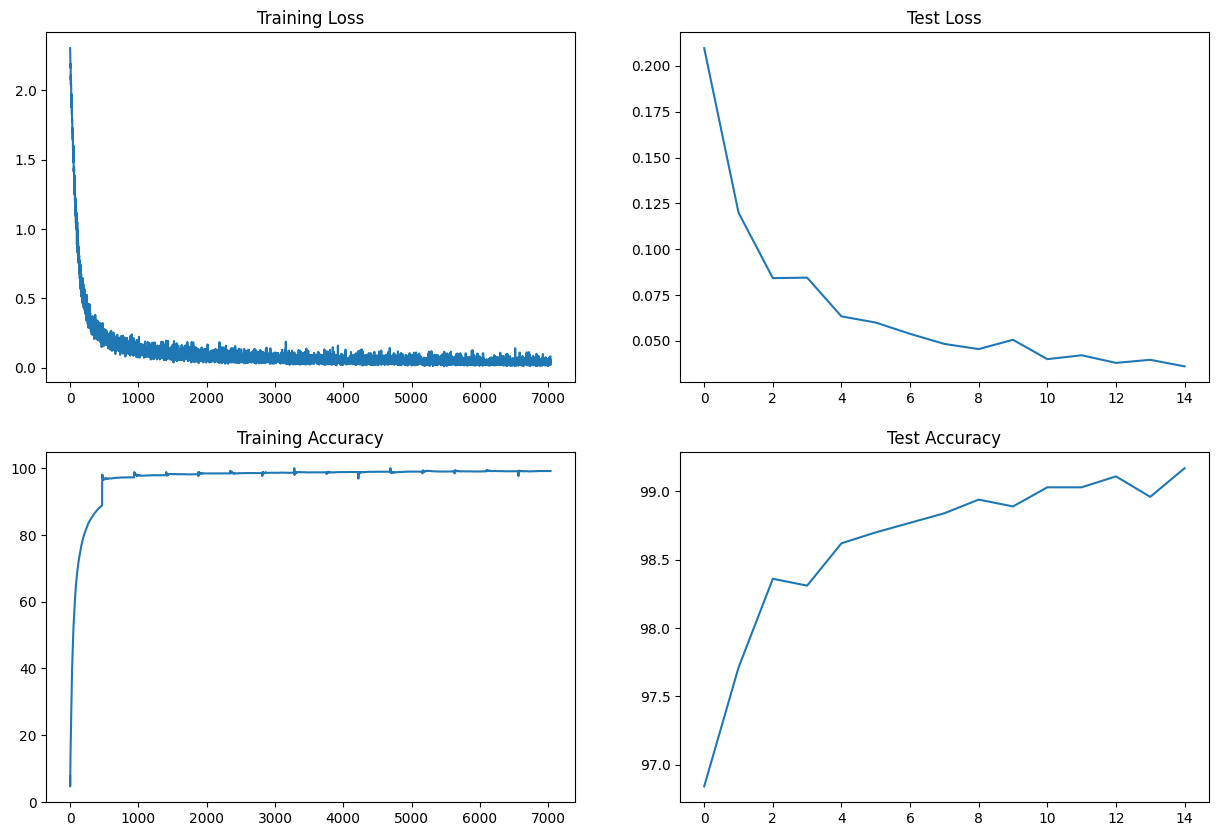

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
train_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_acc]
test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
test_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in test_acc]

axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_cpu)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_cpu)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_cpu)
axs[1, 1].set_title("Test Accuracy")